# Load Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from textblob import TextBlob
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,15)

# Load the data files

Using the Online News Popularity dataset for training. Here I will use the number of shares of the news article as the indication of its virality, since there was no other way to directly predict the virality. 
The dataset is available [here](https://www.kaggle.com/srikaranelakurthy/online-news-popularity)

In [2]:
traindf = pd.read_csv("OnlineNewsPopularity.csv")
traindf.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


The following dataset is the one which we use to test and predict the number of times a particular news article will be shared. The dataset is the one which we get from the scrapy crawler. It contains information about the various news articles from The Times of India online news website. 

In [3]:
testdf = pd.read_csv("newsCrawler/news.csv")
testdf.head()

,url,title,text,keywords,num_images,num_videos,date,full_title,num_hrefs
0,https://timesofindia.indiatimes.com/india/pm-m...,Narendra Modi,PM Modi speaks with Jharkhand CM Hemant Soren ...,"ministers,interacts,lockdown,conference,cms,vi...",13,0,"Apr 27, 2020",Lockdown exit plan: PM Modi interacts with CMs...,387
1,https://timesofindia.indiatimes.com/india/coro...,Coronavirus update,Here is a look at the latest updates on the ou...,"india,hours,health,update,covid19,cases,countr...",13,0,"Apr 27, 2020","Coronavirus latest updates: 886 deaths and 28,...",378
2,https://timesofindia.indiatimes.com/india/day-...,Lockdown news,Here is a look at the latest updates on the ou...,"india,days,state,covid19,lockdown,cases,used,d...",13,0,"Apr 27, 2020",Day 34 of coronavirus lockdown: Ground report ...,377
3,https://timesofindia.indiatimes.com/india/coro...,Coronavirus symptoms,What is coronavirus?\n\nCoronaviruses (CoV) ar...,"symptoms,need,infection,illness,severe,respira...",17,0,"Mar 11, 2020",Coronavirus symptoms and precautions: All you ...,378
4,https://timesofindia.indiatimes.com/india/what...,What is Coronavirus,An illustration of Coronavirus. (Source: Reute...,"india,travel,symptoms,health,source,prevent,vi...",13,0,"Jan 30, 2020",What is Coronavirus and how to prevent it: All...,378


# Preprocessing the data

Using a list of stopwords to remove common words from the article content.

In [4]:
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", 
             "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 
             'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 
             'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 
             'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 
             'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 
             'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 
             'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 
             'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each',
             'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than',
             'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd',
             'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma',
             'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't",
             'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

Using a list of punctuations and special symbols that will removed from the text to get a cleaner text. 

In [5]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '\xa0', '\t',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '\u3000', '\u202f',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '«',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
def clean_text(x):
    x = str(x).replace("\n","")
    x = x.lower()
    for punct in puncts:
        x = x.replace(punct,'')
    return x

In [6]:
traindf.columns

Index(['url', ' timedelta', ' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sent

Helper functions that are used for preprocessing the test data. 

In [7]:
def is_weekend(date):
    if(date.weekday() < 6):
        return 0.0
    else:
        return 1.0
def count_tokens(text):
    words = text.split()
    return len(words)
def uniq_tokens(text):
    words = text.split()
    return len(set(words))
def remove_stopwords(text):
    text = text.lower()
    non_stop_words = [word for word in text.split() if word not in stopwords]
    return ' '.join(non_stop_words)
def average_token_length(text):
    words = text.split()
    total_length = 0
    for word in words:
        total_length+=len(word)
    return total_length/len(words)
def count_keywords(key_text):
    key_arr = key_text.split(',')
    return len(key_arr)
def sentiment_rate(text, calculate_for = 'negative'):
    words = text.split()
    num_negative = 0
    num_positive = 0
    for word in words:
        sentiment = TextBlob(word).sentiment
        if(sentiment.polarity < 0):
            num_negative += 1
        elif(sentiment.polarity > 0):
            num_positive += 1
    if(calculate_for == 'negative'):
        return num_negative/len(words)
    else:
        return num_positive/len(words)
def sentiment_avg(text, calculate_for = 'negative'):
    words = text.split()
    negative_sent = 0
    num_neg = 0.00000001
    positive_sent = 0
    num_pos = 0.00000001
    for word in words:
        sentiment = TextBlob(word).sentiment
        if(sentiment.polarity < 0):
            negative_sent += sentiment.polarity
            num_neg += 1
        elif(sentiment.polarity > 0):
            positive_sent += sentiment.polarity
            num_pos += 1
    if(calculate_for == 'negative'):
        return negative_sent/num_neg
    else:
        return positive_sent/num_pos
def title_subjectivity(title):
    subjectivity = TextBlob(title).sentiment.subjectivity
    return subjectivity
def title_sentiment_polarity(title):
    polarity = TextBlob(title).sentiment.polarity
    return polarity

In [8]:
features_for_minmax = [' n_tokens_title',' n_tokens_content',' n_unique_tokens',' n_non_stop_words',' n_non_stop_unique_tokens',' average_token_length',' num_keywords',' num_hrefs',' num_imgs',' num_videos']
features_for_standard = features_for_minmax.copy()
features_for_minmax.extend([' rate_positive_words',' rate_negative_words', ' avg_positive_polarity',' avg_negative_polarity', ' title_subjectivity',' title_sentiment_polarity'])

In [9]:
def preprocess_test(testdf):
    testdf['text'] = testdf['text'].apply(lambda x:clean_text(x))
    testdf['full_title'] = testdf['full_title'].apply(lambda x:clean_text(x))
    empty_titles_idx = testdf[testdf['full_title'] == '[]'].index
    if(len(empty_titles_idx)>0):
        testdf.loc[empty_titles_idx]['full_title'] = testdf.loc[empty_titles_idx]['title']
    testdf['date'] = pd.to_datetime(testdf['date'], format='%b %d, %Y')
    testdf[' is_weekend'] = testdf['date'].apply(lambda x:is_weekend(x))
    testdf[' n_tokens_title'] = testdf['full_title'].apply(lambda x:count_tokens(x))
    testdf[' n_tokens_content'] = testdf['text'].apply(lambda x:count_tokens(x))
    testdf[' n_unique_tokens'] = testdf['text'].apply(lambda x:uniq_tokens(x))
    testdf['text_without_stopwords'] = testdf['text'].apply(lambda x:remove_stopwords(x))
    testdf[' n_non_stop_words'] = testdf['text_without_stopwords'].apply(lambda x:count_tokens(x))
    testdf[' n_non_stop_unique_tokens'] = testdf['text_without_stopwords'].apply(lambda x:uniq_tokens(x))
    testdf.rename(columns = {'num_hrefs' : ' num_hrefs', 'num_images':' num_imgs', 'num_videos':' num_videos'}, inplace =True)
    testdf[' average_token_length'] = testdf['text'].apply(lambda x: average_token_length(x))
    testdf[' num_keywords'] = testdf['keywords'].apply(lambda x:count_keywords(x))
    testdf[' rate_positive_words'] = testdf['text'].apply(lambda x:sentiment_rate(x,'positive'))
    testdf[' rate_negative_words'] = testdf['text'].apply(lambda x:sentiment_rate(x,'negative'))
    testdf[' avg_positive_polarity'] = testdf['text'].apply(lambda x:sentiment_avg(x, 'positive'))
    testdf[' avg_negative_polarity'] = testdf['text'].apply(lambda x:sentiment_avg(x, 'negative'))
    testdf[' title_subjectivity'] = testdf['full_title'].apply(lambda x:title_subjectivity(x))
    testdf[' title_sentiment_polarity'] = testdf['full_title'].apply(lambda x:title_sentiment_polarity(x))
    minmax = MinMaxScaler()
    testdf[features_for_minmax] = minmax.fit_transform(testdf[features_for_minmax])
    standard = StandardScaler()
    testdf[features_for_standard] = standard.fit_transform(testdf[features_for_standard])
    return testdf

In [10]:
def preprocess_train(traindf):
    minmax = MinMaxScaler()
    traindf[features_for_minmax] = minmax.fit_transform(traindf[features_for_minmax])
    standard = StandardScaler()
    traindf[features_for_standard] = standard.fit_transform(traindf[features_for_standard])
    return traindf

In [11]:
traindf = preprocess_train(traindf)

# Feature Engineering

From all the features available from the pre-computed dataset, only a handful of features could be recreated for our purposes. Thus, I manually select the features that I can reproduce for testing purpose. 

In [12]:
selected_cols = [' is_weekend',' n_tokens_title',' n_tokens_content',' n_unique_tokens',' n_non_stop_words',' n_non_stop_unique_tokens',
                ' num_hrefs',' num_imgs',' num_videos',' average_token_length',' num_keywords',' rate_positive_words',' rate_negative_words',
                ' avg_positive_polarity',' avg_negative_polarity',' title_subjectivity',' title_sentiment_polarity']
x = traindf[selected_cols]
y = np.array(traindf[' shares'].values.tolist())

Splitting the dataset for train and validation of the trained models. 

In [13]:
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=123)

# Feature Importance


I now fit a basic xgboost regressor on the training data. 

In [14]:
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror',max_depth=5,learning_rate = 0.01, n_estimators=100)
xgb_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

Using the trained xgboost regressor, I now plot a graph to highlight the importance of various features in the dataset. It can be seen that the number of words in the content has a huge impact on the virality, as well as the number of images in the article. 

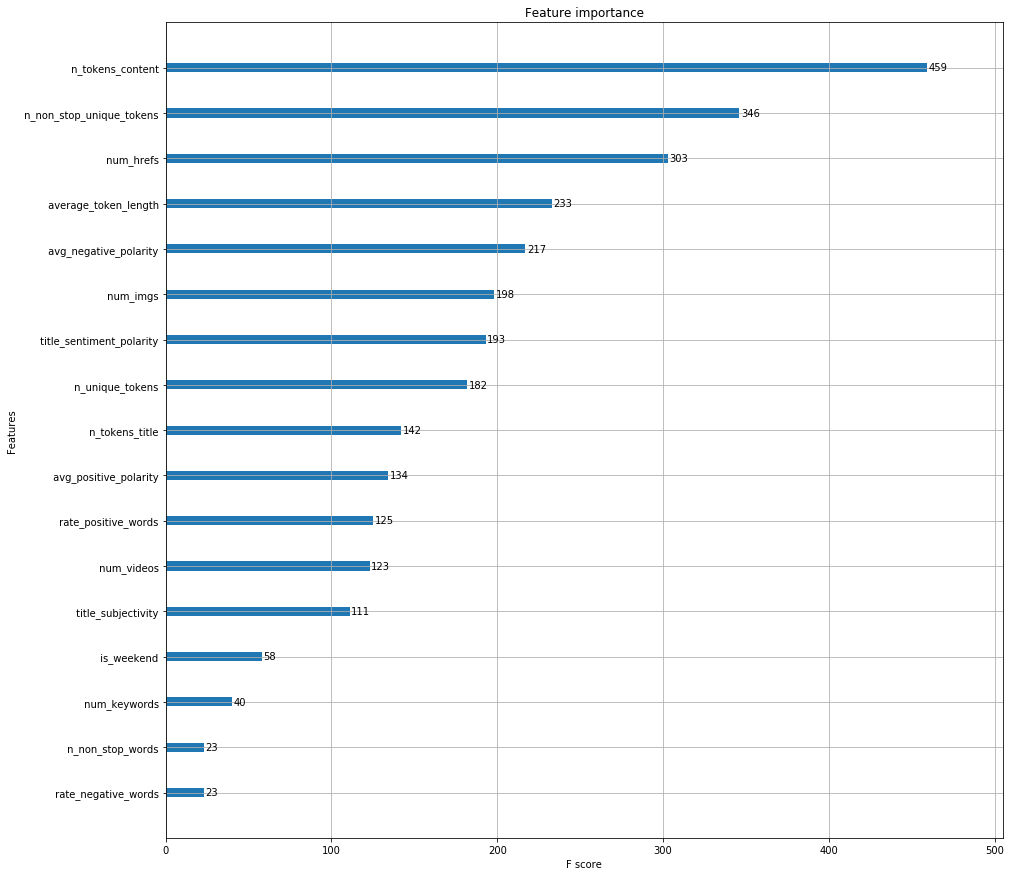

In [15]:
xgb.plot_importance(xgb_reg)

In [16]:
y_pred = xgb_reg.predict(X_train)
error = mean_absolute_error(y_train,y_pred)
print("The train mae error is : ", error)
y_pred = xgb_reg.predict(X_val)
error = mean_absolute_error(y_val,y_pred)
print("The validation mae error is : ", error)

The train mae error is :  2490.109216841677
The validation mae error is :  2648.9037591282545


# Model Creation

<li>Creating a function to create a neural network model using Tensorflow. 
<li>The model architecture was created using AutoKeras to find the best set of hyperparameters for the task at hand. 

In [17]:
def build_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(128,activation='relu', input_shape=[X_train.shape[1]]))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(32, activation='relu'))
  model.add(tf.keras.layers.Dense(32, activation='relu'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(1, activation='relu'))

  optimizer = tf.keras.optimizers.Adam(0.1)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [18]:
tf_reg = build_model()
try:
    tf_reg.load_weights('tensorflow_regressor.h5')
except:
    print('Pretrained Weights not available')

Pretrained Weights not available


In [19]:
EPOCHS = 50

history = tf_reg.fit(
  X_train.to_numpy(), y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose = 2)

Train on 25372 samples, validate on 6343 samples
Epoch 1/50
25372/25372 - 4s - loss: 143449019.8594 - mae: 3080.3613 - mse: 143449104.0000 - val_loss: 79952942.4050 - val_mae: 2931.8379 - val_mse: 79952952.0000
Epoch 2/50
25372/25372 - 2s - loss: 142227552.5152 - mae: 3158.9932 - mse: 142227536.0000 - val_loss: 79958475.7314 - val_mae: 3025.6128 - val_mse: 79958488.0000
Epoch 3/50
25372/25372 - 2s - loss: 142055177.6771 - mae: 3150.6624 - mse: 142055200.0000 - val_loss: 80322016.6461 - val_mae: 3118.8279 - val_mse: 80322000.0000
Epoch 4/50
25372/25372 - 2s - loss: 141819533.1086 - mae: 3153.1401 - mse: 141819504.0000 - val_loss: 80305610.7615 - val_mae: 2921.3464 - val_mse: 80305600.0000
Epoch 5/50
25372/25372 - 2s - loss: 141992628.2680 - mae: 3126.5974 - mse: 141992592.0000 - val_loss: 80319198.2797 - val_mae: 3173.2117 - val_mse: 80319200.0000
Epoch 6/50
25372/25372 - 2s - loss: 141685052.6083 - mae: 3150.9714 - mse: 141685008.0000 - val_loss: 80086398.9008 - val_mae: 2805.6428 - va

In [20]:
tf_reg.save('tensorflow_regressor.h5')

In [21]:
origdf = testdf.copy()
testdf = preprocess_test(testdf)

In [22]:
testdf = testdf[selected_cols]

In [23]:
pred = tf_reg.predict(testdf.to_numpy())
pred = pred.reshape((len(pred),))
xg_pred = xgb_reg.predict(testdf)

## Ensembling 

Ensembling the predictions from the xgboost regressor and the neural network model by using weighted average to get the final predictions. I give greater weightage to the xgboost model because it was giving superior results. 

In [24]:
ensembled_results = (pred * 0.3 + xg_pred * 0.7).astype('int32')

In [25]:
origdf['shares'] = ensembled_results
origdf[['title','shares']]

,title,shares
0,Narendra Modi,9583
1,Coronavirus update,3436
2,Lockdown news,2673
3,Coronavirus symptoms,7978
4,What is Coronavirus,2859
5,Solar Eclipse,2757
6,NPR,34374
7,What is NRC,4719
8,CAB Bill,2192
9,RTI Bill,3467
